In [2]:
from load_sim_data import *
from load_shp import *
from sim_eval_pkg import *

Updated on 2025-10-14


In [3]:
def prepare_data(data_array):
    array = data_array.values.flatten()
    array = array[~np.isnan(array)]
    array = array[array>0]
    return array

def compute_boxplot_stats(data):
    stats = {
        'med': np.percentile(data, 50),
        'q1': np.percentile(data, 25),
        'q3': np.percentile(data, 75),
        'whislo': np.percentile(data, 1),   
        'whishi': np.percentile(data, 99),
        'mean': np.nanmean(data),
        'std': np.nanstd(data)
    }
    return stats

In [8]:
def extract_mod_obs_10cities(var_name, obs_xr, period='JJA'):
    ctrl=(eval(f'ctrl_{period}_avg_1d32deg_reg')[var_name])
    test=(eval(f'test_{period}_avg_1d32deg_reg')[var_name])
    obs=obs_xr+273.15
    mask=(ctrl>0) & (obs>0) & (test>0)
    ctrl=ctrl.where(mask)
    test=test.where(mask)
    obs=obs.where(mask)
    
    city_array = {}
    city_stats = {}
    
    datasets = [
        {'name': 'ctrl', 'variable': ctrl, 'color': '#9fc5e8'},
        {'name': 'test', 'variable': test, 'color': '#f4cccc'},
        {'name': 'obs', 'variable': obs, 'color': '#93c47d'}
    ]
    
    all_boxplot_data = []
    colors_for_boxes = []
    positions = []
    city_positions = []
    pos = 1 
    
    for city in PRISM_cities:
        city_name = city['name']
        city_shapefile = city['shapefile']
        city_waterFrac = city['water']
        for dataset in datasets:
            dataset_name = dataset['name']
            dataset_variable = dataset['variable']
            color = dataset['color']
    
            clipped_data = clip_netcdf_by_shp(dataset_variable, city_shapefile).where(city_waterFrac>0.0)
            data_array = prepare_data(clipped_data)
            city_array[(city_name,dataset_name)]=data_array
    
            if dataset_name == 'obs':
                obs_data = data_array
                ctrl_data = city_array.get((city_name, 'ctrl'))
                test_data = city_array.get((city_name, 'test'))
                
                if ctrl_data is not None and test_data is not None:
                    mask_ctrl = (~np.isnan(ctrl_data)) & (~np.isnan(obs_data)) & (~np.isnan(test_data))
                    #mask_test = (~np.isnan(test_data)) & (~np.isnan(obs_data))
                    
                    ctrl_vals = ctrl_data[mask_ctrl].flatten()
                    test_vals = test_data[mask_ctrl].flatten()
                    obs_vals_ctrl = obs_data[mask_ctrl].flatten()
                    obs_vals_test = obs_data[mask_ctrl].flatten()
            
                    if len(ctrl_vals) > 0 and len(obs_vals_ctrl) > 0:
                        R_ctrl, _ = pearsonr(ctrl_vals, obs_vals_ctrl)
                        RMSE_ctrl = np.sqrt(mean_squared_error(obs_vals_ctrl, ctrl_vals))
                        MAE_ctrl = mean_absolute_error(obs_vals_ctrl, ctrl_vals)
                    else:
                        R_ctrl, RMSE_ctrl, MAE_ctrl = np.nan, np.nan, np.nan
            
                    if len(test_vals) > 0 and len(obs_vals_test) > 0:
                        R_test, _ = pearsonr(test_vals, obs_vals_test)
                        RMSE_test = np.sqrt(mean_squared_error(obs_vals_test, test_vals))
                        MAE_test = mean_absolute_error(obs_vals_test, test_vals)
                    else:
                        R_test, RMSE_test, MAE_test = np.nan, np.nan, np.nan
            
                    city_stats[city_name] = {
                        'R_ctrl': R_ctrl,
                        'RMSE_ctrl': RMSE_ctrl,
                        'MAE_ctrl': MAE_ctrl,
                        'R_test': R_test,
                        'RMSE_test': RMSE_test,
                        'MAE_test': MAE_test
                    }
    
            stats = compute_boxplot_stats(data_array)
            box_data = {
                'med': stats['med'],
                'q1': stats['q1'],
                'q3': stats['q3'],
                'whislo': stats['whislo'],
                'whishi': stats['whishi'],
                'fliers': []
            }
            all_boxplot_data.append(box_data)
            colors_for_boxes.append(color)
            positions.append(pos)
            pos += 1
        city_positions.append(pos - 2)
        pos += 0.5

    return all_boxplot_data, colors_for_boxes, positions, city_positions, city_stats

In [9]:
def boxplot_PRISM(var_name, obs_xr, ylabel, period):
    all_boxplot_data, colors_for_boxes, positions, city_positions, city_stats=extract_mod_obs_10cities(var_name, obs_xr, period)
    fig, ax = plt.subplots(figsize=(15, 8))
    boxplot = ax.bxp(all_boxplot_data, positions=positions, showfliers=False, patch_artist=True,widths=0.7)
    
    num_boxes = len(boxplot['boxes'])
    for i in range(num_boxes):
        box = boxplot['boxes'][i]
        whisker_left = boxplot['whiskers'][2 * i]
        whisker_right = boxplot['whiskers'][2 * i + 1]
        cap_left = boxplot['caps'][2 * i]
        cap_right = boxplot['caps'][2 * i + 1]
        median = boxplot['medians'][i]
        
        color = colors_for_boxes[i]
        
        box.set_facecolor('none')        
        box.set_edgecolor(color)         
        box.set_linewidth(3)          
        
        # Set whisker properties
        whisker_left.set_color(color)
        whisker_right.set_color(color)
        whisker_left.set_linewidth(3)
        whisker_right.set_linewidth(3)
        whisker_left.set_linestyle('dashed')    # Set left whisker to dashed line
        whisker_right.set_linestyle('dashed') 
        
        # Set cap properties
        cap_left.set_color(color)
        cap_right.set_color(color)
        cap_left.set_linewidth(3)
        cap_right.set_linewidth(3)
        
        median.set_color(color)
        median.set_linewidth(2.5)
    
    ax.set_xticks(city_positions)
    ax.set_xticklabels([city['name'] for city in PRISM_cities], ha='center',fontsize=28)
    
    ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(axis='y', labelsize=20)
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    ax.set_title('')
    
    legend_handles = [
        mpatches.Patch(facecolor='none', edgecolor='#9fc5e8', label='CTRL', linewidth=3),
        mpatches.Patch(facecolor='none', edgecolor='#f4cccc', label='USURF', linewidth=3),
        mpatches.Patch(facecolor='none', edgecolor='#93c47d', label='PRISM', linewidth=3)
    ]
    ax.legend(handles=legend_handles,fontsize=20)
    
    plt.tight_layout()

    city_stats = pd.DataFrame(city_stats)
    city_stats['average'] = city_stats.mean(axis=1)
    return fig, city_stats

___

### Figure 5a

___

,PHX,LAX,CHI,DNV,POR,BAL,MIA,DAL,BOS,ATL,average
R_ctrl,0.270020,-0.603522,0.791732,0.122890,0.602864,0.194219,0.279901,0.464332,0.417922,0.878884,0.341924
RMSE_ctrl,0.528602,1.830472,1.267921,1.527085,0.558683,1.353475,1.098802,1.379935,1.473129,1.477647,1.249575
MAE_ctrl,0.430439,1.623937,1.235852,1.297739,0.452920,1.222844,1.066348,1.302834,1.431425,1.466533,1.153087
R_test,0.324785,-0.642718,0.845604,0.151792,0.654414,0.199676,0.533347,0.228401,0.507110,0.877021,0.367943
RMSE_test,0.563302,1.866533,0.987459,1.613041,0.373192,1.030679,0.998914,1.238279,0.874094,1.196544,1.074203
MAE_test,0.474296,1.655980,0.956262,1.390889,0.309340,0.866907,0.969836,1.134080,0.810177,1.180640,0.974841


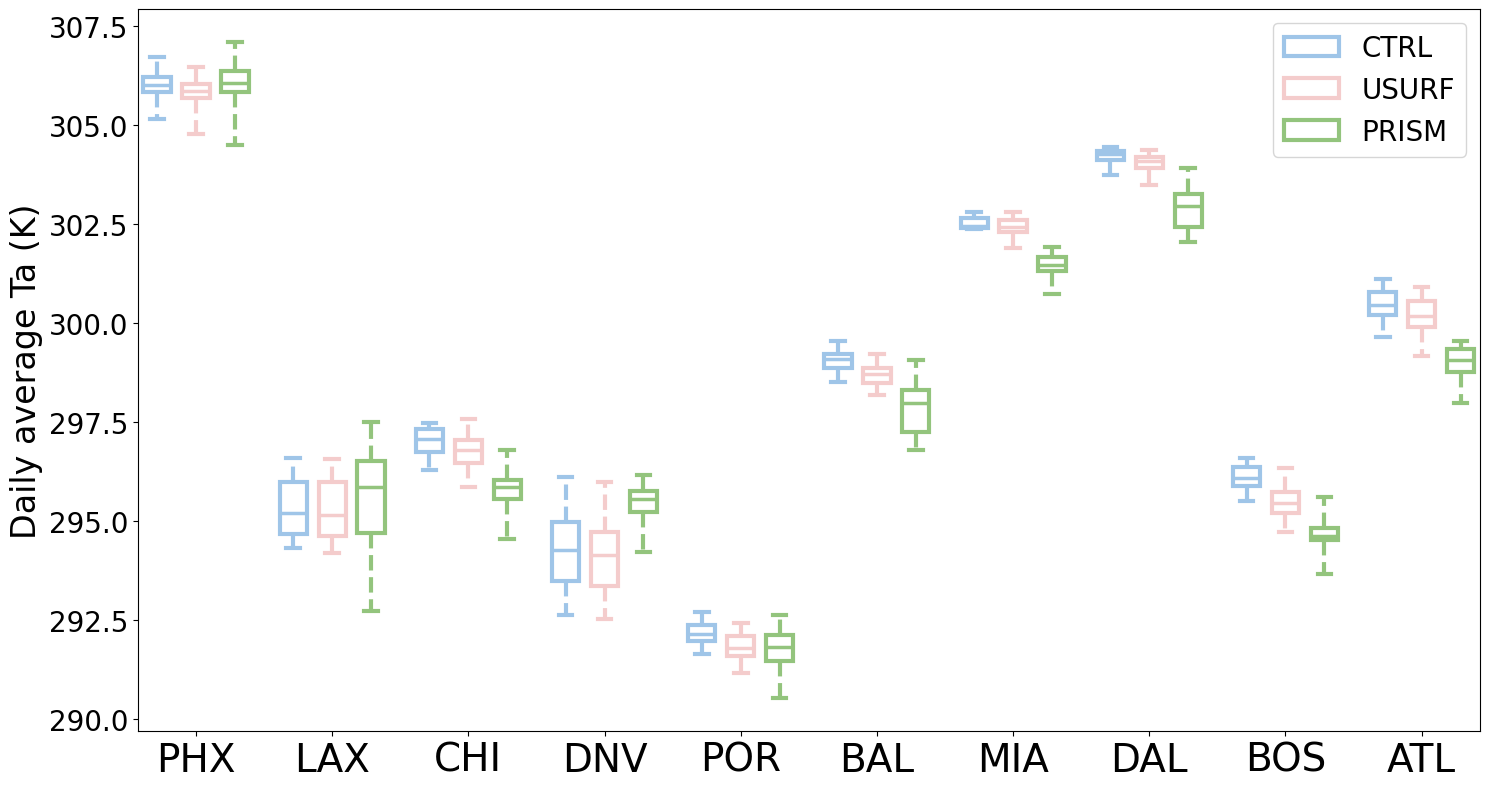

In [10]:
var_name='TSA_U'
ylabel='Daily average Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_JJA_xr, ylabel,'JJA')
city_stats

___

### Figure 5b

___

,PHX,LAX,CHI,DNV,POR,BAL,MIA,DAL,BOS,ATL,average
R_ctrl,-0.344624,0.494027,0.912942,-0.207818,0.397479,0.231509,0.307139,0.266492,0.383072,0.713879,0.315410
RMSE_ctrl,1.706479,1.273024,1.341511,2.309503,1.115423,1.440458,0.861222,0.917018,1.636106,1.635132,1.423588
MAE_ctrl,1.484616,1.104203,1.262636,2.006324,0.964802,1.259805,0.702742,0.745549,1.501028,1.602147,1.263385
R_test,-0.377981,0.495869,0.916894,-0.222942,0.265964,0.199180,0.410103,0.151581,0.527267,0.725700,0.309164
RMSE_test,1.690347,1.288392,0.977471,2.426888,0.925806,1.433651,0.920153,0.865857,1.210526,1.557406,1.329650
MAE_test,1.452259,1.121729,0.901381,2.123031,0.758372,1.273139,0.781207,0.707136,1.087656,1.523125,1.172904


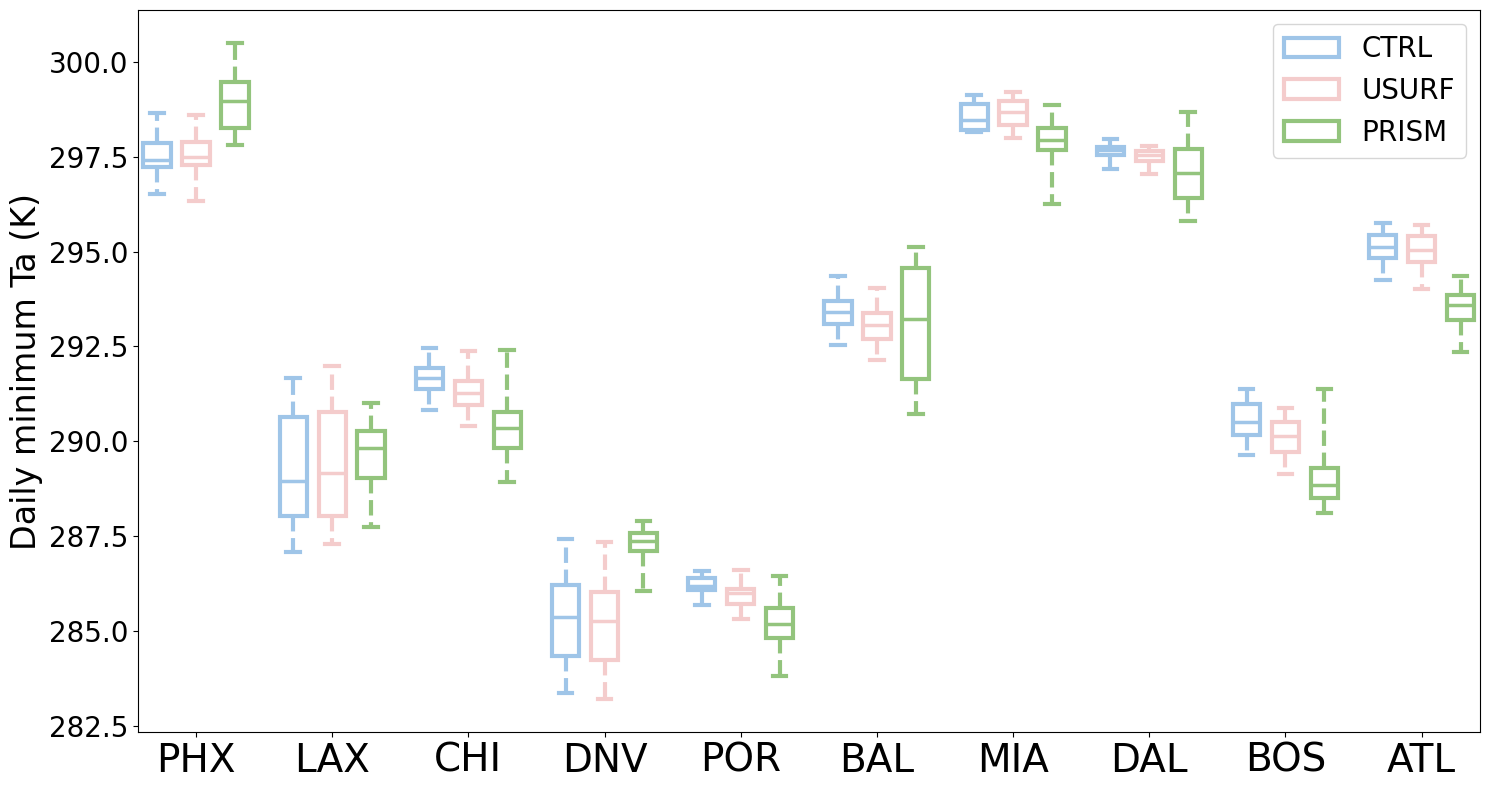

In [11]:
var_name='TREFMNAV_U'
ylabel='Daily minimum Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_JJA_Tmin_xr, ylabel,'JJA')
city_stats

___

### Figure 5c

___

,PHX,LAX,CHI,DNV,POR,BAL,MIA,DAL,BOS,ATL,average
R_ctrl,0.588743,0.259423,0.608917,0.342436,0.638611,0.297774,-0.293759,0.657247,0.254153,0.812475,0.416602
RMSE_ctrl,1.515693,3.256271,2.088435,1.019147,1.889114,3.191818,3.039066,2.738751,2.253997,2.591227,2.358352
MAE_ctrl,1.431128,2.490857,2.040305,0.780057,1.854922,3.146020,2.973240,2.723148,2.154826,2.580611,2.217511
R_test,0.643070,0.218749,0.527229,0.458769,0.627411,0.365715,-0.339929,0.433924,-0.115660,0.809135,0.362841
RMSE_test,1.119364,3.214230,1.886603,0.796727,1.378844,2.648118,2.655817,2.467488,1.457834,1.925416,1.955044
MAE_test,1.018620,2.481593,1.814150,0.632468,1.312335,2.596067,2.572487,2.438651,1.226679,1.907357,1.800041


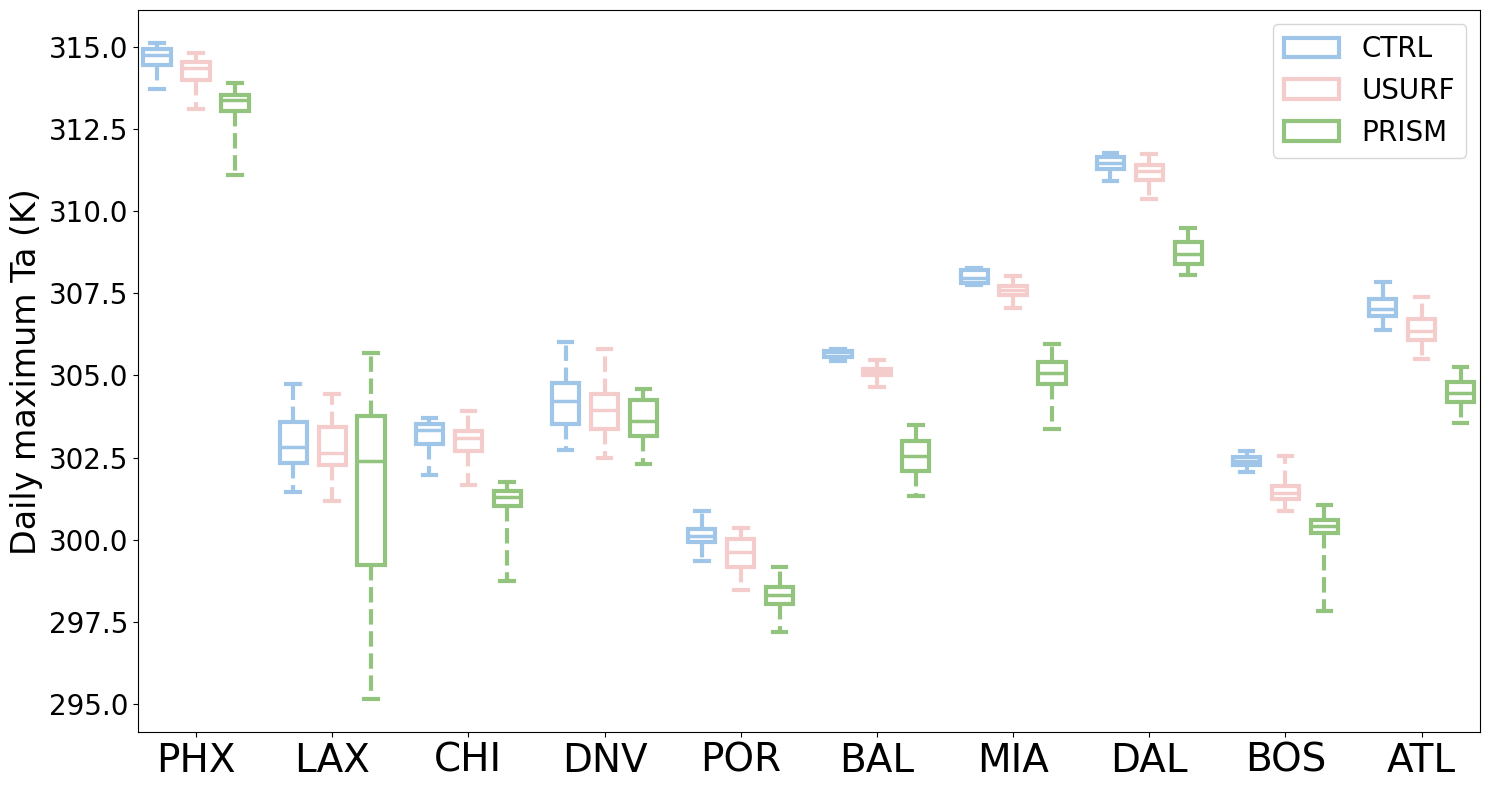

In [12]:
var_name='TREFMXAV_U'
ylabel='Daily maximum Ta (K)'
fig,city_stats=boxplot_PRISM(var_name, PRISM_JJA_Tmax_xr, ylabel,'JJA')
city_stats